## 1. Install the required packages

In [1]:
pip install pandas numpy yfinance matplotlib seaborn statsmodels tensorflow


Note: you may need to restart the kernel to use updated packages.


## 2. Download historical price data

In [2]:
import yfinance as yf

# Fetch historical stock price data
aapl = yf.Ticker("AAPL")
data = aapl.history(period="5y", interval="1d")

# Display the first few rows
print(data.head())


                                Open       High        Low      Close  \
Date                                                                    
2019-12-10 00:00:00-05:00  65.100761  65.457047  64.436661  65.071678   
2019-12-11 00:00:00-05:00  65.151649  65.706680  65.076515  65.626694   
2019-12-12 00:00:00-05:00  64.902015  66.060547  64.790527  65.793938   
2019-12-13 00:00:00-05:00  65.793915  66.724617  65.665459  66.688263   
2019-12-16 00:00:00-05:00  67.136665  68.055252  67.131820  67.829842   

                              Volume  Dividends  Stock Splits  
Date                                                           
2019-12-10 00:00:00-05:00   90420400        0.0           0.0  
2019-12-11 00:00:00-05:00   78756800        0.0           0.0  
2019-12-12 00:00:00-05:00  137310400        0.0           0.0  
2019-12-13 00:00:00-05:00  133587600        0.0           0.0  
2019-12-16 00:00:00-05:00  128186000        0.0           0.0  


## 3. Explore the dataset

In [4]:
import pandas as pd

# Check for missing values
print(data.isnull().sum())

# Data summary
print(data.describe())


Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
              Open         High          Low        Close        Volume  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1.258000e+03   
mean    150.004063   151.669694   148.467905   150.154594  9.143084e+07   
std      41.625263    41.827537    41.430627    41.659255  5.332514e+07   
min      55.411089    55.513126    51.652716    54.509758  2.404830e+07   
25%     125.420980   126.872742   123.836418   125.030659  5.601990e+07   
50%     149.170285   151.717717   147.811729   149.616425  7.703395e+07   
75%     175.851254   177.655635   174.396090   176.258560  1.088613e+08   
max     243.990005   247.240005   242.130005   246.750000  4.265100e+08   

         Dividends  Stock Splits  
count  1258.000000   1258.000000  
mean      0.003595      0.003180  
std       0.028374      0.112777  
min       0.000000      0.000000  
25%       

## 4. Handle missing data

In [5]:
# Fill missing values with interpolation
data.interpolate(inplace=True)

# Confirm missing values are handled
print(data.isnull().sum())


Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


## 5. Visualize price trends

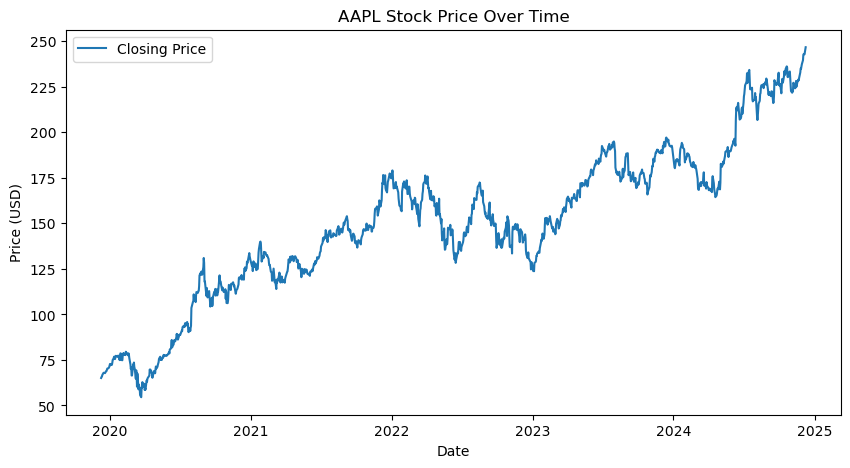

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the closing prices
plt.figure(figsize=(10, 5))
sns.lineplot(data=data['Close'], label='Closing Price')
plt.title('AAPL Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


## 6. Split the dataset

In [7]:
# Define training and testing split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

print(f"Training set size: {len(train)}, Testing set size: {len(test)}")


Training set size: 1006, Testing set size: 252


## 7. Build a baseline model

In [8]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Baseline model: Exponential Smoothing
model = ExponentialSmoothing(train['Close'], trend='add', seasonal=None)
model_fit = model.fit()

# Forecast
baseline_forecast = model_fit.forecast(steps=len(test))

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error
baseline_mse = mean_squared_error(test['Close'], baseline_forecast)
baseline_mae = mean_absolute_error(test['Close'], baseline_forecast)

print(f"Baseline MSE: {baseline_mse}, MAE: {baseline_mae}")


/opt/anaconda3/envs/py_econ/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/py_econ/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/py_econ/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Baseline MSE: 301.17667998097045, MAE: 13.722352552523766


## 8. Implement a deep learning model

In [9]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Step 8.1: Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Close']])

# Create sequences for LSTM
def create_sequences(data, sequence_length=60):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length, 0])
        targets.append(data[i + sequence_length, 0])
    return np.array(sequences), np.array(targets)

sequence_length = 60  # 60 days of historical data for prediction
train_scaled = data_scaled[:train_size]
test_scaled = data_scaled[train_size:]

X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

# Reshape data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Step 8.2: Build the LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Step 8.3: Train the Model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), verbose=1)

# Step 8.4: Make Predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)  # Rescale predictions

# Rescale the test set's true values for comparison
true_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Save the predictions and true values for evaluation
forecast_results = pd.DataFrame({
    'True Prices': true_prices.flatten(),
    'Predicted Prices': predicted_prices.flatten()
})

forecast_results.head()


Epoch 1/10


/opt/anaconda3/envs/py_econ/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0890 - val_loss: 0.0082
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0033 - val_loss: 0.0049
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 9.0913e-04 - val_loss: 0.0012
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 9.1377e-04 - val_loss: 0.0013
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 8.6693e-04 - val_loss: 0.0016
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 9.2994e-04 - val_loss: 0.0015
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 8.1198e-04 - val_loss: 0.0016
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.3105e-04 - val_loss: 0.0014
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 7.9335e-04 - val_loss: 0.0010
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


,True Prices,Predicted Prices
0,168.390701,182.253769
1,170.114441,180.858002
2,172.127182,179.571075
3,172.605438,178.524948
4,170.513031,177.707855


## 8.5 Evaluate the LSTM

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Calculate evaluation metrics
lstm_mse = mean_squared_error(forecast_results['True Prices'], forecast_results['Predicted Prices'])
lstm_mae = mean_absolute_error(forecast_results['True Prices'], forecast_results['Predicted Prices'])

print(f"LSTM Model MSE: {lstm_mse}, MAE: {lstm_mae}")


LSTM Model MSE: 37.49292098327475, MAE: 5.003657976786298


## 9. Visualization

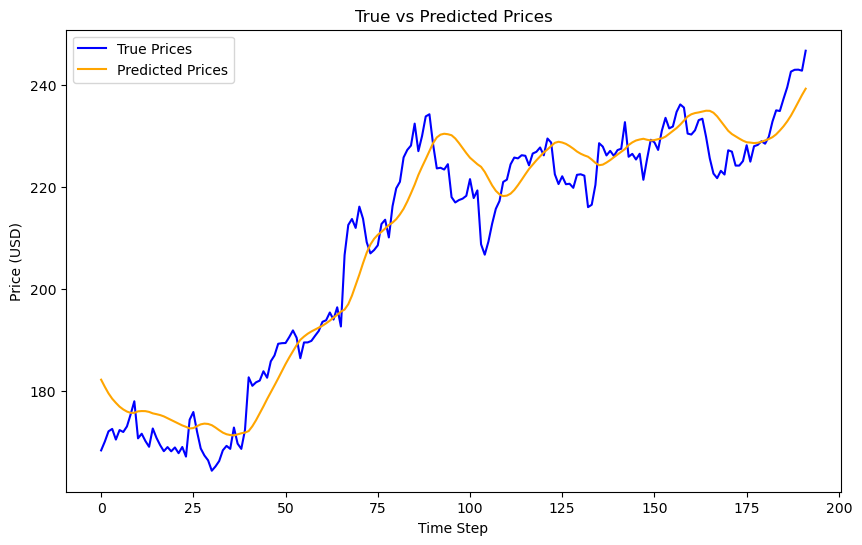

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(forecast_results['True Prices'], label='True Prices', color='blue')
plt.plot(forecast_results['Predicted Prices'], label='Predicted Prices', color='orange')
plt.title('True vs Predicted Prices')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


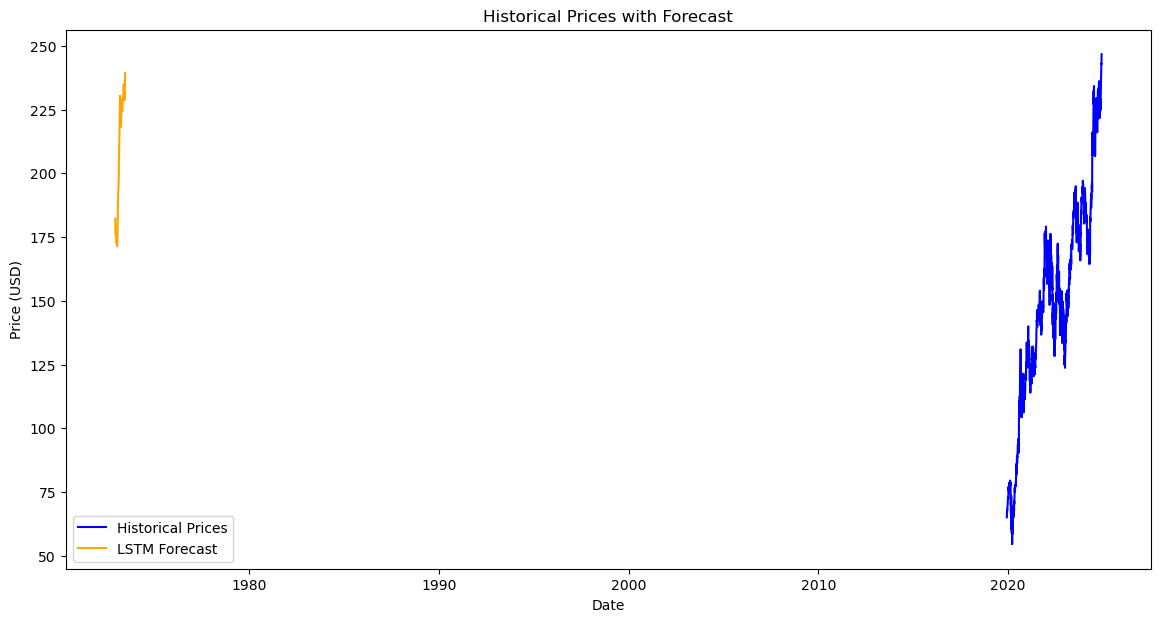

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Historical Prices', color='blue')
plt.plot(range(len(train) + sequence_length, len(data)), forecast_results['Predicted Prices'], label='LSTM Forecast', color='orange')
plt.title('Historical Prices with Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [13]:
forecast_results.to_csv('forecast_results.csv', index=False)
print("Forecast results saved as 'forecast_results.csv'")

Forecast results saved as 'forecast_results.csv'
